In [231]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [232]:
x_MainFoil, y_MainFoil = numpy.loadtxt('MainFoil_N=100.csv', delimiter=',', unpack=True)
x_FlapFoil, y_FlapFoil = numpy.loadtxt('FlapFoil_N=100.csv', delimiter=',', unpack=True)

In [233]:
COLUMN = numpy.concatenate((x_MainFoil, x_FlapFoil), axis=0)

(-0.25, 0.2)

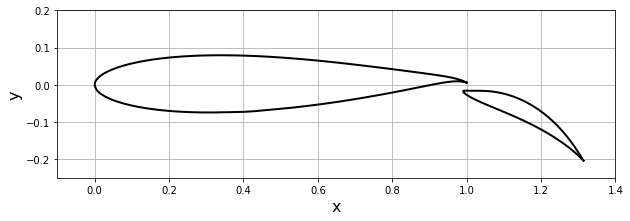

In [234]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, x_FlapFoil, y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.2)

MAINFOIL PANEL CLASS

In [235]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0 

In [236]:
x_ends = x_MainFoil
y_ends = y_MainFoil

N = 100
panels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

FLAPFOIL PANEL CLASS

In [237]:
class Panel_FP:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0 

In [238]:
x_ends2 = x_FlapFoil
y_ends2 = y_FlapFoil

N = 100
panels_fp = numpy.empty(N, dtype=object)
for i in range(N):
    panels_fp[i] = Panel_FP(x_ends2[i], y_ends2[i], x_ends2[i + 1], y_ends2[i + 1])

FREESTREAM CLASS

In [239]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [240]:
u_inf = 1.0                            
alpha = 0.0                            
freestream = Freestream(u_inf, alpha)  

GETTING SIGMA AND GAMMA

In [241]:
def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [242]:
def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

In [243]:
A_source_main = source_contribution_normal(panels)
B_vortex_main = vortex_contribution_normal(panels)
A_source_flap = source_contribution_normal(panels_fp)
B_vortex_flap = vortex_contribution_normal(panels_fp)

In [244]:
COLUMN.shape[0]

202

Building primary matrix

In [245]:
def build_a_matrix(A_source_main, B_vortex_main, A_source_flap, B_vortex_flap):
    A = numpy.empty((COLUMN.shape[0] - 2, COLUMN.shape[0] - 2), dtype=float)
    A[:-100, :-100] = A_source_main
    A[100:, :-100] = B_vortex_main
    A[:-100, 100:] = B_vortex_flap
    A[100:, 100:] = A_source_flap
    return A

In [246]:
A_a = build_a_matrix(A_source_main, B_vortex_main, A_source_flap, B_vortex_flap)

In [266]:
def build_B_matrix(B_vortex_main, B_vortex_flap):
    A = numpy.empty((2, A_a.shape[0]), dtype=float)
    A[0, :-100] = B_vortex_main[0, :] + B_vortex_main[-1, :]
    A[0, 100:] = B_vortex_flap[0, :] + B_vortex_flap[-1, :]
    A[1, :-100] = B_vortex_main[0, :] + B_vortex_main[-1, :]
    A[1, 100:] = B_vortex_flap[0, :] + B_vortex_flap[-1, :]
    return A

In [267]:
B_B = build_B_matrix(B_vortex_main, B_vortex_flap)

In [247]:
def build_b_matrix(B_vortex_main, B_vortex_flap):
    A = numpy.empty((A_a.shape[0], 2), dtype=float)
    A[:100, 0] = numpy.sum(B_vortex_main, axis=1)
    A[100:, 0] = numpy.sum(B_vortex_flap, axis=1)
    A[:100, 1] = numpy.sum(B_vortex_flap, axis=1)
    A[100:, 1] = numpy.sum(B_vortex_main, axis=1)
    return A

In [248]:
B_b = build_b_matrix(B_vortex_main, B_vortex_flap)

In [249]:
def build_RHS_b_matrix(panels, panels_fp, freestream):
    b = numpy.empty(panels.size + panels_fp.size, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    for j, panel in enumerate(panels_fp):
        b[100 + j] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    return b

In [250]:
b_b = build_RHS_b_matrix(panels, panels_fp, freestream)

In [276]:
B_b.shape

(200, 2)

Building linear system

In [268]:
def kutta_condition(B_vortex_main, B_vortex_flap, B_b):
    b = numpy.empty(2, A_a.shape[0] + 2, dtype=float)
    b[:, :-2] = B_B
    b[:, -2] = - numpy.sum(A_source_main[0, :] + A_source_main[-1, :])
    b[:, -1] = - numpy.sum(A_source_flap[0, :] + A_source_flap[-1, :])
    return b

In [272]:
def build_singularity_matrix(A_source_main, B_vortex_main, A_source_flap, B_vortex_flap, A_a):
    A = numpy.empty((A_a.shape[0] + 2, A_a.shape[1] + 2), dtype=float)
    A[:-2, :-2] = A_a
    A[:-2, 200:] = B_b
    A[200:, :] = kutta_condition(B_vortex_main, B_vortex_flap)
    return A

In [273]:
def build_freestream_rhs(panels, panels_fp, freestream):
    b = numpy.empty(panels.size + panels_fp.size + 2, dtype=float)
    b[:-2] = b_b
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels_fp[0].beta) +
                                 numpy.sin(freestream.alpha - panels_fp[-1].beta) )
    return b

In [277]:
A = build_singularity_matrix(A_source_main, B_vortex_main, A_source_flap, B_vortex_flap, A_a)
b = build_freestream_rhs(panels, panels_fp, freestream)

TypeError: kutta_condition() missing 1 required positional argument: 'B_b'